In [2]:
!mkdir food_dataset
!./google-cloud-sdk/bin/gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead" ./food_dataset
!./google-cloud-sdk/bin/gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/metadata" ./food_dataset
!./google-cloud-sdk/bin/gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids" ./food_dataset

mkdir: cannot create directory ‘food_dataset’: File exists
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556572657/depth_color.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556572657/depth_raw.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556572657/rgb.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556573514/depth_raw.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556573514/depth_color.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556575014/depth_raw.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556573514/rgb.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556575014/rgb.png...
Copying gs://nutrition5k_dataset/nutrition5k_datase

In [5]:
# prompt: create a dataloader for the nutrition5k_dataset. Filenames are located inside the food_dataset/dish_ids/splits/rgb_train_ids.txt for training and  food_dataset/dish_ids/splits/rgb_test_ids.txt for testing.
# for each filename inside the text, the file is located in:  food_dataset/realsense_overhead/<FILENAME>/rgb.png. 

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import csv

class Nutrition5kDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform

        if split == 'train':
            split_file = os.path.join(data_dir, 'dish_ids', 'splits', 'rgb_train_ids.txt')
        elif split == 'test':
            split_file = os.path.join(data_dir, 'dish_ids', 'splits', 'rgb_test_ids.txt')
        else:
            raise ValueError("Invalid split. Choose 'train' or 'test'.")

        with open(split_file, 'r') as f:
            self.image_ids = [line.strip() for line in f]
            self.image_ids = [image_id for image_id in self.image_ids if os.path.exists(os.path.join(data_dir, 'realsense_overhead', image_id, 'rgb.png'))]

    def __len__(self):
        return len(self.image_ids)

    def get_csv_line(self, image_id):
      csv_files = [
          "./food_dataset/metadata/dish_metadata_cafe1.csv",
          "./food_dataset/metadata/dish_metadata_cafe2.csv"
      ]

      for csv_file in csv_files:
          if os.path.exists(csv_file):
              with open(csv_file, 'r', encoding='utf-8') as file:
                  reader = csv.reader(file) 
                  for row in reader:
                      if row and row[0] == image_id:  
                          return row  
      return None  

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.data_dir, 'realsense_overhead', image_id, 'rgb.png')
        
        try:
          image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
          print(f"Warning: Image file not found at {image_path}. Skipping.")
          # Return a placeholder or handle the error as needed
          return None, None

        if self.transform:
            image = self.transform(image)

        return image, ",".join(self.get_csv_line(image_id))
      

# Example Usage
data_dir = './food_dataset'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Nutrition5kDataset(data_dir, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) # Adjust num_workers as needed


test_dataset = Nutrition5kDataset(data_dir, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2) # Adjust num_workers as needed


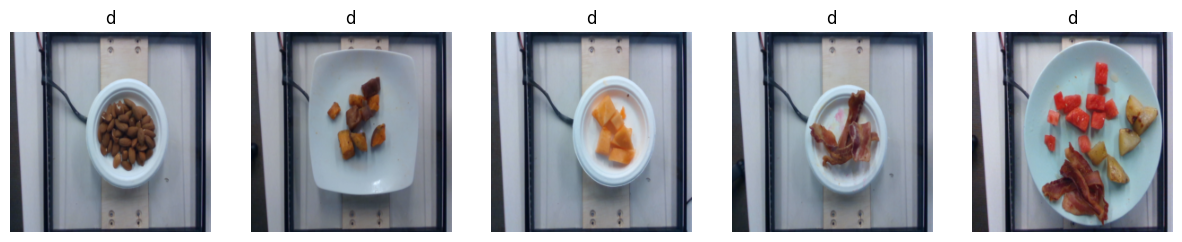

In [6]:
# prompt: create a function to visualize samples from the train_dataset

import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(dataset, num_samples=5):
    """Visualizes samples from the dataset."""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        sample, target = dataset[i]
        if sample is not None:  # Check for potential None values
          # Convert tensor to numpy array and handle different image formats
          if isinstance(sample, torch.Tensor):
              image = sample.permute(1, 2, 0).numpy()
          elif isinstance(sample, np.ndarray):
              image = sample
          else: # Assuming it's PIL image
              image = np.array(sample)

          # Normalize pixel values to the range 0-1 for display
          image = (image - image.min()) / (image.max() - image.min())

          axes[i].imshow(image)
          axes[i].set_title(target[0])
          axes[i].axis('off')
    plt.show()

# Visualize samples from train_dataset
visualize_samples(train_dataset)


In [7]:
# prompt: create a custom pytorch model that uses pre trained weights of a current state of the art image classification model of your choice and create custom final layer with 1665 units, choose a small model (under 5m params if possible)

import torch
import torch.nn as nn
from torchvision import models

class CustomModel(nn.Module):
    def __init__(self, num_classes=555):
        super(CustomModel, self).__init__()
        # Load a pre-trained MobileNetV2 model (small model)
        self.model = models.mobilenet_v2(pretrained=True)

        # Modify the final classification layer
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Example usage:
model = CustomModel()

# Print the model architecture (optional)
# print(model)

# Check the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Example input (replace with your actual input)
# input_tensor = torch.randn(1, 3, 224, 224) # Example input (batch_size, channels, height, width)
# output = model(input_tensor)
# print(output.shape) # Verify output shape


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/zeus/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 128MB/s]

Total number of parameters: 2934827


In [8]:
def evaluate():
  model.eval()
  threshold_a = 0.5
  threshold_a = 0.7
  correct_predictions = 0
  total_predictions = 0
  with torch.no_grad():
      for images, labels_raw in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Evaluation"):
          if images is None:
              continue

          images = images.to(device)
          labels = convert_labels(labels_raw)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total_predictions += labels.size(0)
          correct_predictions += (predicted == labels).sum().item()

  accuracy = 100 * correct_predictions / total_predictions
  print(f"Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%")

In [9]:
# prompt: create a pipeline to train and evalute this model using the datasets, the labels for the images will be processed in a future function called "convert_labels" using the second return element of the dataset.

import torch
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel().to(device)
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001) # Example optimizer


def convert_labels(labels):
    # Placeholder: Implement your label conversion logic here.
    # This will take the output from get_csv_line() and convert it to numerical labels.
    # Example: Convert string labels to numerical IDs.
    targets = torch.zeros(len(labels), 555).to(device)
    for i, label in enumerate(labels):
        label = label.split(",")
        # ... your conversion logic ...
        #print(label)
        dish_id, total_calories, total_mass, total_fat, total_carb, total_protein = label[:6]
        ingrs = label[6:]
        for j in range(len(ingrs)//7):
          k = j*7
          #print(ingrs[k:k+7])
          ingr_id = int(ingrs[k].replace("ingr_", "")) - 1
          ingr_name = ingrs[k+1]
          ingr_mass = ingrs[k+2]

          relative_mass = float(ingr_mass) / float(total_mass)

          targets[i, ingr_id] = relative_mass

    return targets

num_epochs = 10  # Set the number of epochs

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0

  for images, labels_raw in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
      # Skip if images is None (due to missing image files)
      if images is None:
          continue

      images = images.to(device)
      labels = convert_labels(labels_raw)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

  epoch_loss = running_loss / len(train_loader)
  print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

  # Evaluation loop


print("Training finished.")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 - Training: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s]


Epoch [1/10], Training Loss: 0.1588


Epoch 2/10 - Training: 100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


Epoch [2/10], Training Loss: 0.0100


Epoch 3/10 - Training: 100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


Epoch [3/10], Training Loss: 0.0088


Epoch 4/10 - Training: 100%|██████████| 11/11 [00:06<00:00,  1.61it/s]


Epoch [4/10], Training Loss: 0.0081


Epoch 5/10 - Training: 100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


Epoch [5/10], Training Loss: 0.0078


Epoch 6/10 - Training: 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


Epoch [6/10], Training Loss: 0.0075


Epoch 7/10 - Training: 100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


Epoch [7/10], Training Loss: 0.0068


Epoch 8/10 - Training: 100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


Epoch [8/10], Training Loss: 0.0061


Epoch 9/10 - Training: 100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Epoch [9/10], Training Loss: 0.0054


Epoch 10/10 - Training: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s]

Epoch [10/10], Training Loss: 0.0048
Training finished.


In [10]:
torch.save(model.state_dict(), 'model_weights.pth')